<h1>Рекомендация тарифов<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"></ul></div>

Нужно построить систему, способную проанализировать поведение клиентов и предложить пользователям новый тариф: «Смарт» или «Ультра».

**В нашем распоряжении данные о поведении клиентов, которые уже перешли на эти тарифы**

**Цель:** построить систему, способную проанализировать поведение клиентов и предложить пользователям новый тариф: «Смарт» или «Ультра».

**Задачи:** 
1. Построить модель для задачи классификации, которая выберет подходящий тариф.
2. Построить модель с максимально большим значением *accuracy*

**Ход работы:**
1. Изучить данные
2. Разделить исходные данные на обучающую, валидационную и тестовую выборки.
3. Исследовать качество разных моделей, меняя гиперпараметры. Написать выводы исследования.
4. Проверить качество модели на тестовой выборке.
5. Дополнительное задание: проверить модели на вменяемость.

# Изучение данных

In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split 
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
from sklearn.dummy import DummyClassifier 
from tqdm import tqdm
from sklearn import tree
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import learning_curve

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import f1_score

import warnings
warnings.filterwarnings('ignore')
import seaborn as sns

In [2]:
data = pd.read_csv('.\\data\\users_behavior.csv')
data.head()

,calls,minutes,messages,mb_used,is_ultra
0,40.0,311.90,83.0,19915.42,0
1,85.0,516.75,56.0,22696.96,0
2,77.0,467.66,86.0,21060.45,0
3,106.0,745.53,81.0,8437.39,1
4,66.0,418.74,1.0,14502.75,0


In [3]:
print('Размер датафрейма:', data.shape)

Размер датафрейма: (3214, 5)


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3214 entries, 0 to 3213
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   calls     3214 non-null   float64
 1   minutes   3214 non-null   float64
 2   messages  3214 non-null   float64
 3   mb_used   3214 non-null   float64
 4   is_ultra  3214 non-null   int64  
dtypes: float64(4), int64(1)
memory usage: 125.7 KB


In [5]:
data.describe()

,calls,minutes,messages,mb_used,is_ultra
count,3214.000000,3214.000000,3214.000000,3214.000000,3214.000000
mean,63.038892,438.208787,38.281269,17207.673836,0.306472
std,33.236368,234.569872,36.148326,7570.968246,0.461100
min,0.000000,0.000000,0.000000,0.000000,0.000000
25%,40.000000,274.575000,9.000000,12491.902500,0.000000
50%,62.000000,430.600000,30.000000,16943.235000,0.000000
75%,82.000000,571.927500,57.000000,21424.700000,1.000000
max,244.000000,1632.060000,224.000000,49745.730000,1.000000


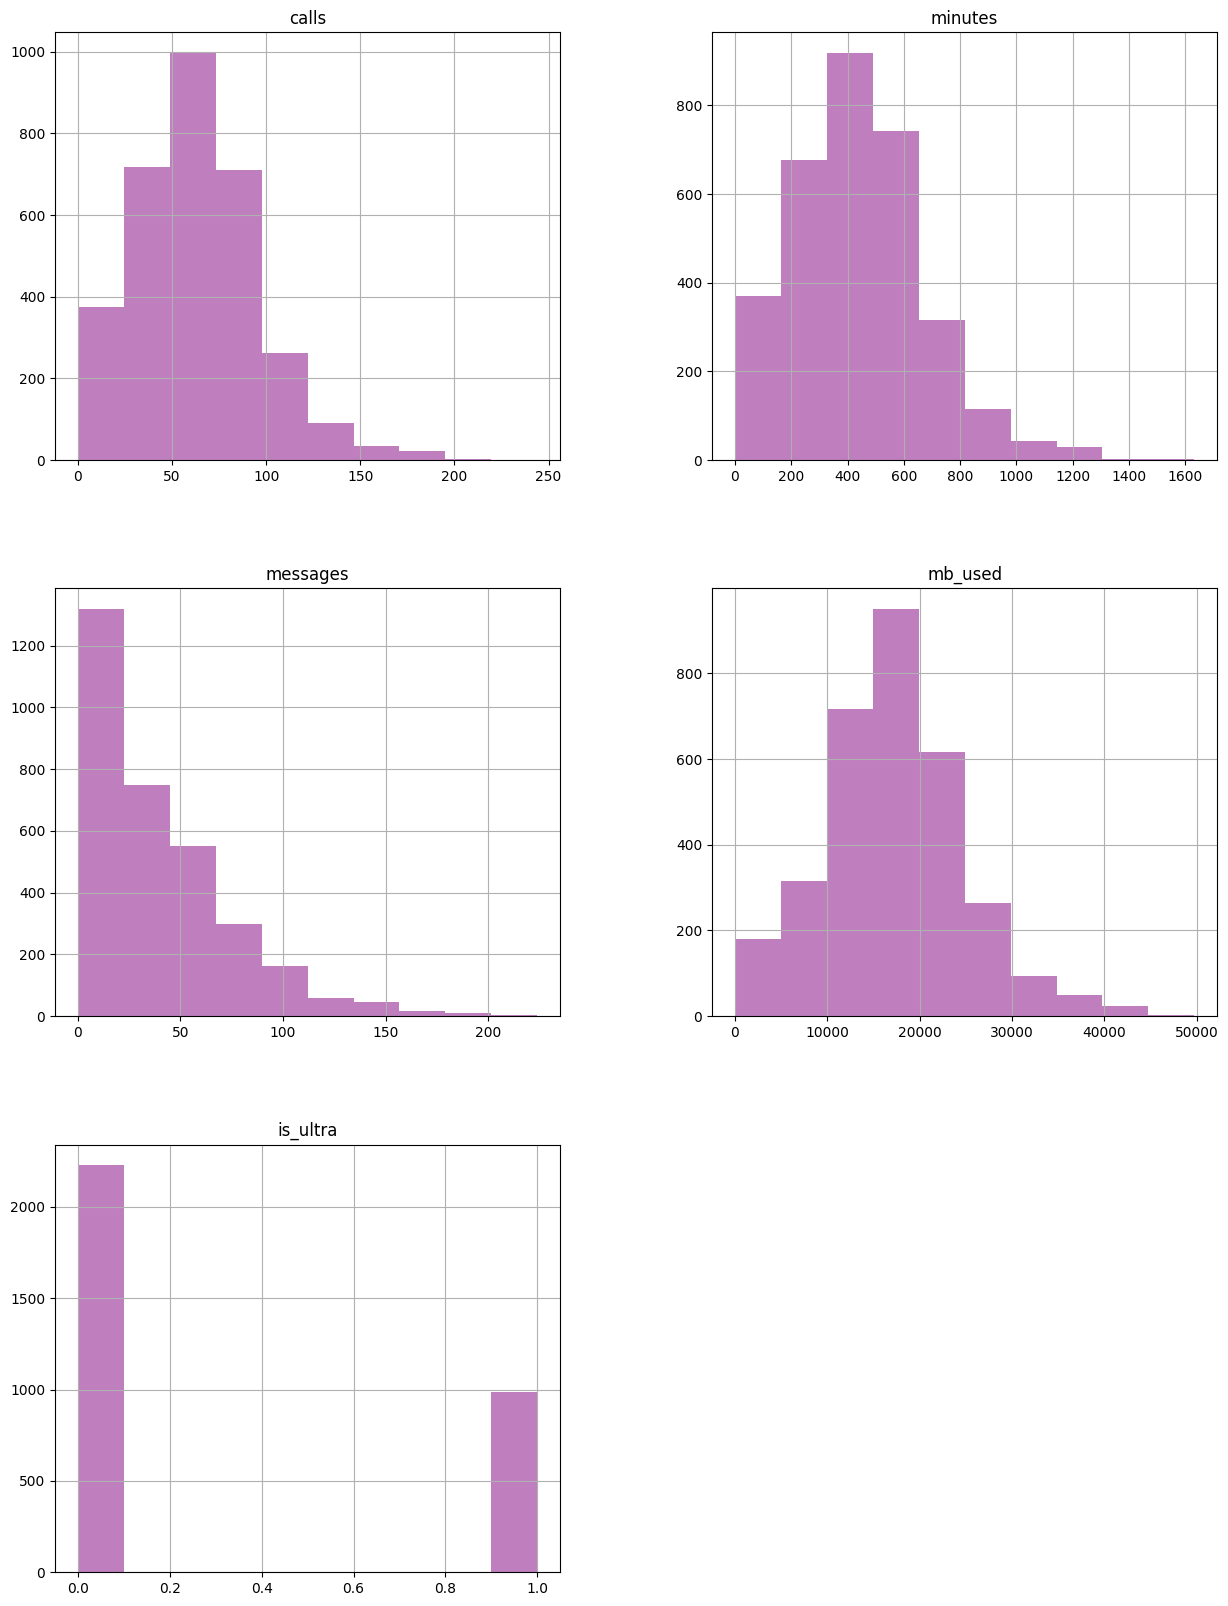

In [6]:
data.hist(figsize = (15,20), alpha =0.5, color='purple');

In [7]:
data_visualization = data.copy()
data_visualization.loc[data_visualization['is_ultra']== 0, 'is_ultra'] = 'Cмарт'
data_visualization.loc[data_visualization['is_ultra']== 1, 'is_ultra'] = 'Ультра'
data_visualization.head()

,calls,minutes,messages,mb_used,is_ultra
0,40.0,311.90,83.0,19915.42,Cмарт
1,85.0,516.75,56.0,22696.96,Cмарт
2,77.0,467.66,86.0,21060.45,Cмарт
3,106.0,745.53,81.0,8437.39,Ультра
4,66.0,418.74,1.0,14502.75,Cмарт


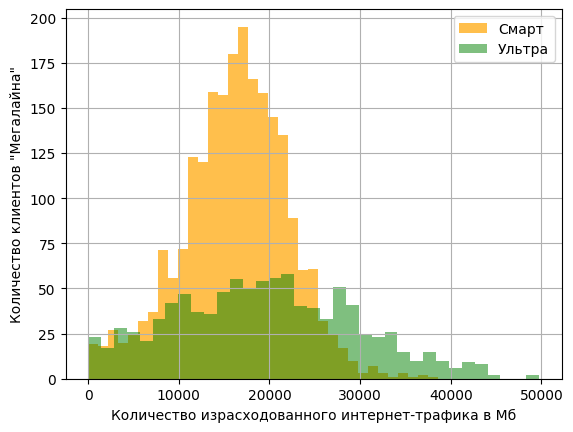

In [8]:
data_visualization[data_visualization['is_ultra'] =='Cмарт']['mb_used'].hist(bins=35, alpha=0.7, color='orange')
data_visualization[data_visualization['is_ultra'] =='Ультра']['mb_used'].hist(bins=35, alpha=0.5, color='green');
plt.legend(['Смарт', 'Ультра'])
plt.xlabel('Количество израсходованного интернет-трафика в Мб')
plt.ylabel('Количество клиентов "Мегалайна"')
plt.show()

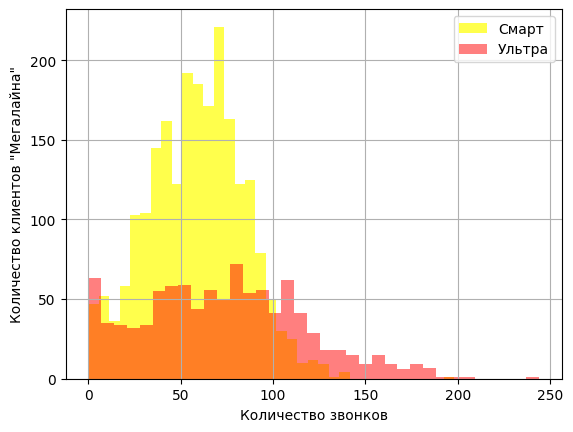

In [9]:
data_visualization[data_visualization['is_ultra'] =='Cмарт']['calls'].hist(bins=35, alpha=0.7, color='yellow')
data_visualization[data_visualization['is_ultra'] =='Ультра']['calls'].hist(bins=35, alpha=0.5, color='red');
plt.legend(['Смарт', 'Ультра'])
plt.xlabel('Количество звонков')
plt.ylabel('Количество клиентов "Мегалайна"')
plt.show()

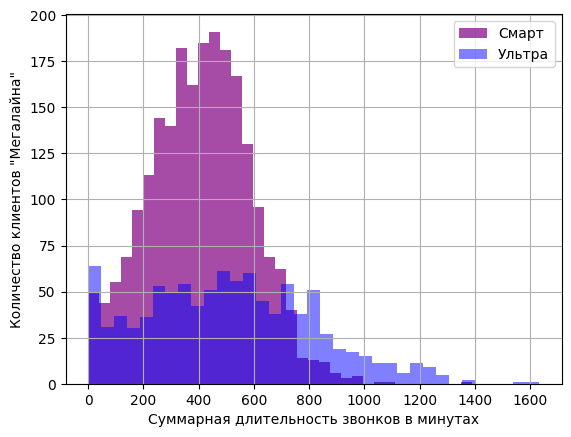

In [10]:
data_visualization[data_visualization['is_ultra'] =='Cмарт']['minutes'].hist(bins=35, alpha=0.7, color='purple')
data_visualization[data_visualization['is_ultra'] =='Ультра']['minutes'].hist(bins=35, alpha=0.5, color='blue')
plt.legend(['Смарт', 'Ультра'])
plt.xlabel('Суммарная длительность звонков в минутах')
plt.ylabel('Количество клиентов "Мегалайна"')
plt.show()

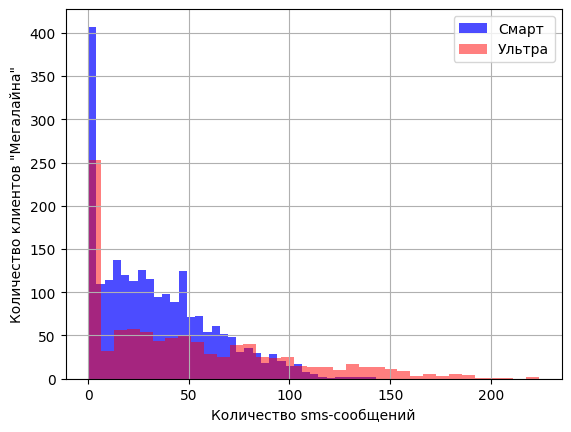

In [11]:
data_visualization[data_visualization['is_ultra'] =='Cмарт']['messages'].hist(bins=35, alpha=0.7, color='blue')
data_visualization[data_visualization['is_ultra'] =='Ультра']['messages'].hist(bins=35, alpha=0.5, color='red');
plt.legend(['Смарт', 'Ультра'])
plt.xlabel('Количество sms-сообщений')
plt.ylabel('Количество клиентов "Мегалайна"')
plt.show()

>У клиентов пользуется спросом больше тариф "Смарт", чем "Ультра" (дисбаланс)

>Пропусков нет, данные в порядке, можно идти дальше

**Мультиколлинеарность** — корреляция независимых переменных, которая затрудняет оценку и анализ общего результата. Она может стать причиной переобучения модели для регрессии

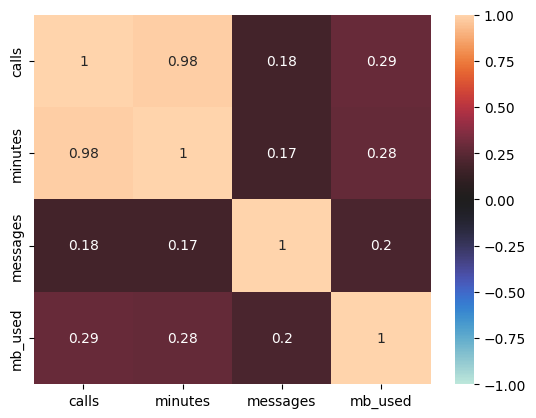

In [12]:
sns.heatmap(data_visualization.select_dtypes(include=[np.number]).corr(), annot = True, vmin=-1, vmax=1, center= 0);

>Количество звонков сильно зависит от суммарной длительности звонков 🍒

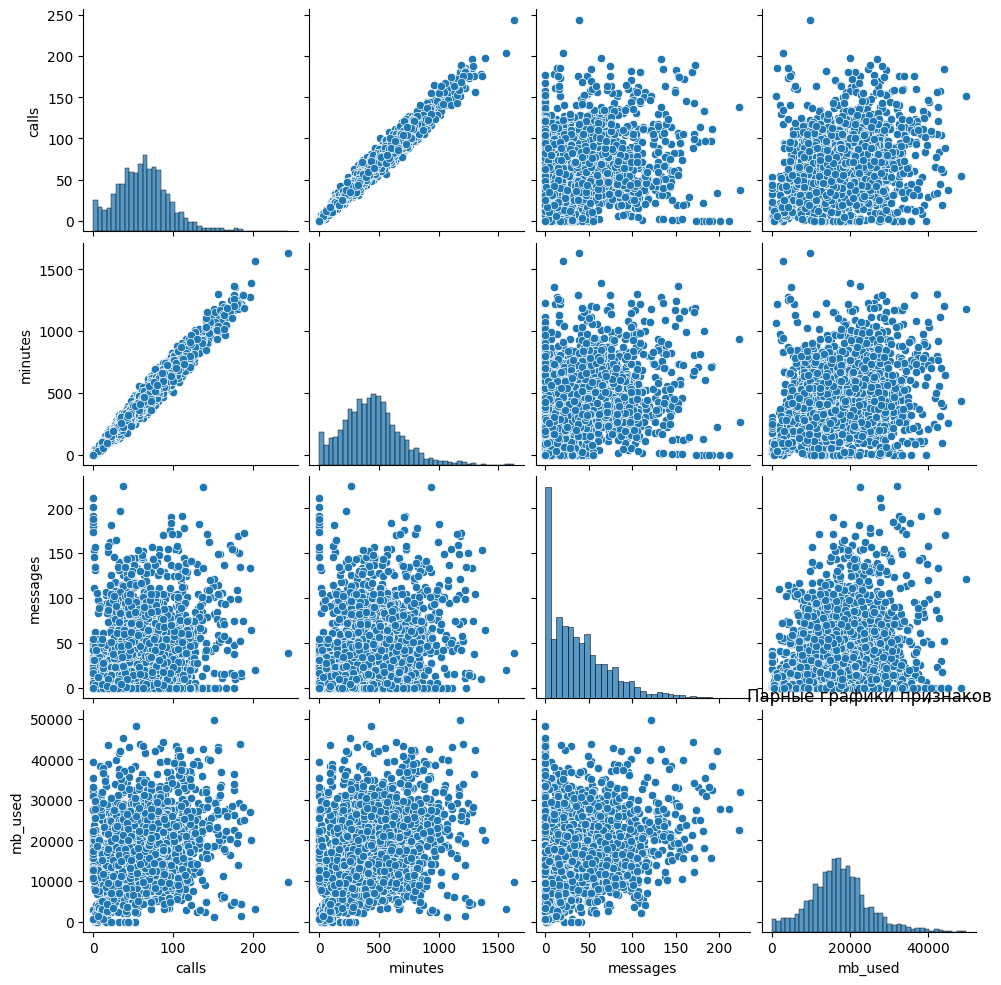

In [13]:
sns.pairplot(data_visualization)
plt.title('Парные графики признаков')
plt.show()

и эта зависимость линейная

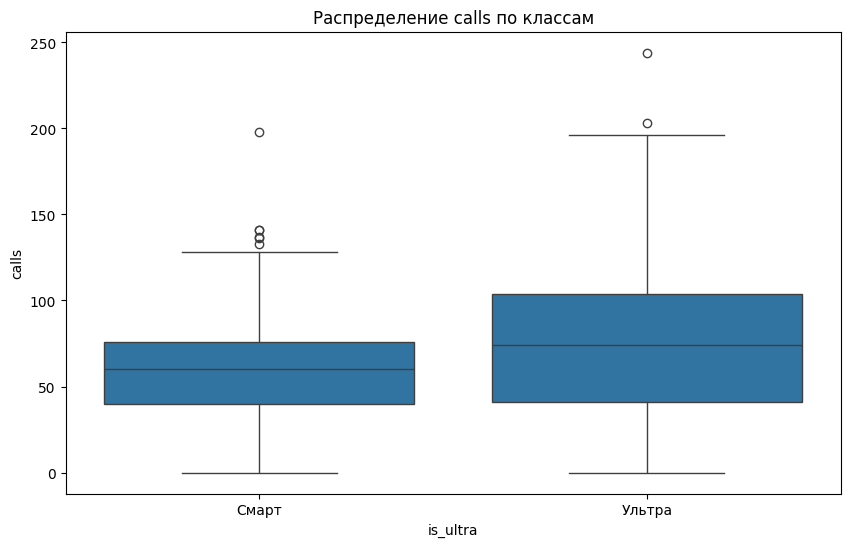

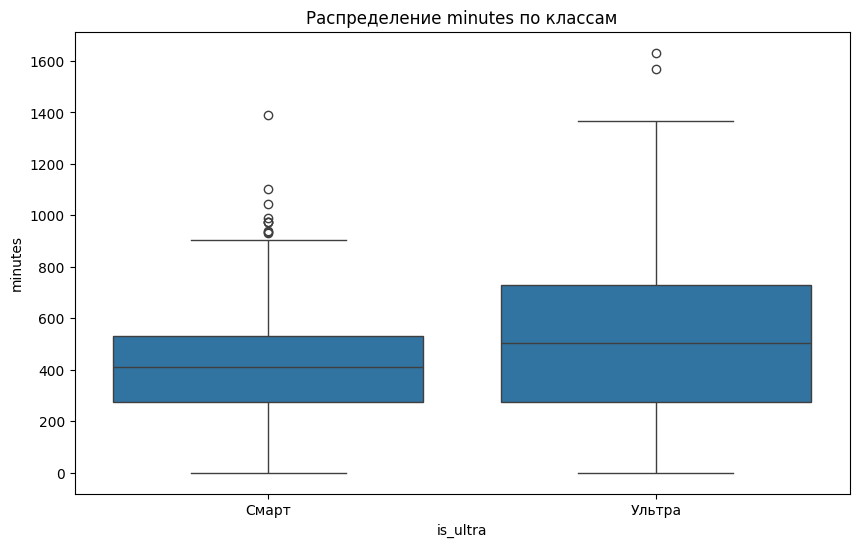

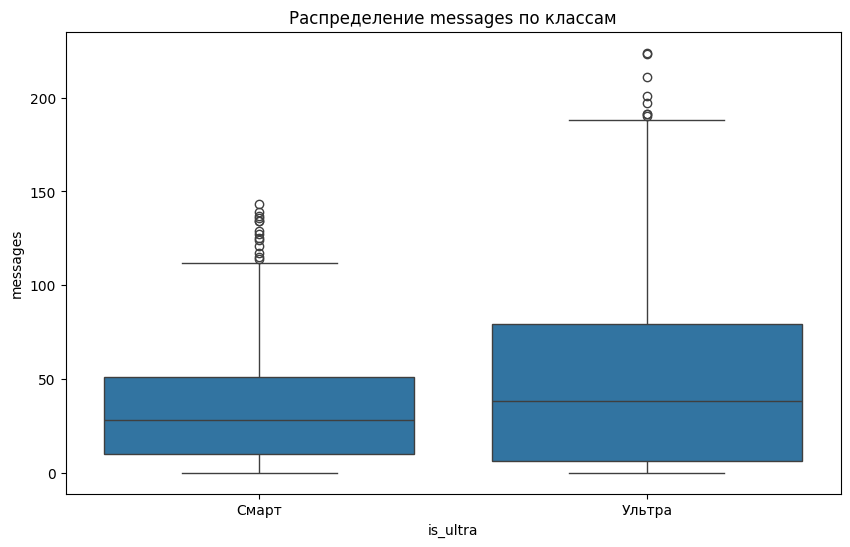

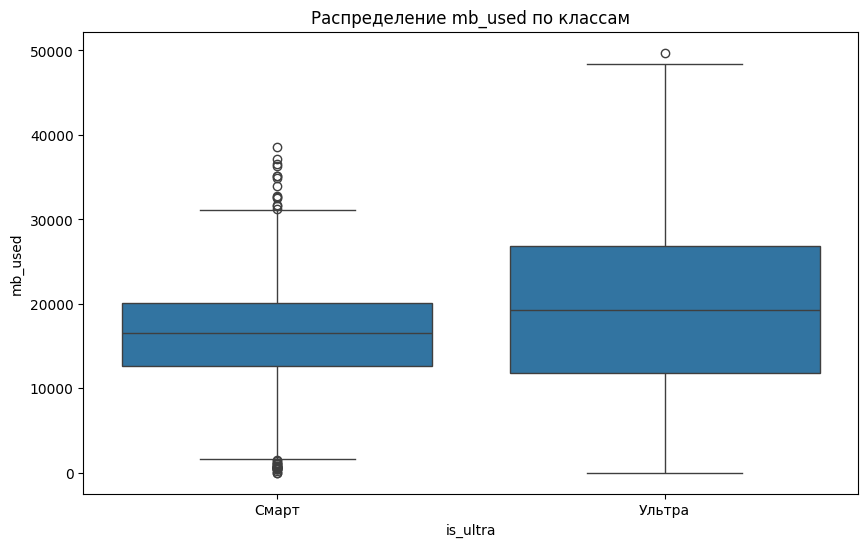

In [14]:
for column in data_visualization.drop(['is_ultra'], axis=1).columns:
    plt.figure(figsize=(10, 6))
    sns.boxplot(x=data_visualization["is_ultra"], y=data_visualization[column])
    plt.title(f'Распределение {column} по классам')
    plt.show()

In [15]:
# # очень тяжелая, но полезная штука
# from ydata_profiling import ProfileReport

# profile = ProfileReport(data, title="Pandas Profiling Report")
# profile.to_notebook_iframe()

Мы имеем задачу бинарной классификации с несбалансированными данными.

**Модели для бинарной классификации**
1. Логистическая регрессия (Logistic Regression):

    * Простой и интерпретируемый алгоритм.
    * Хорошо работает на линейно разделимых данных.

2. Дерево решений (Decision Tree):

    * Способно выявлять сложные нелинейные зависимости.
    * Могут переобучаться, но хорошо объясняют решения.

3. Случайный лес (Random Forest):

    * Композиция деревьев решений.
    * Снижает вероятность переобучения по сравнению с одиночными деревьями.

4. Градиентный бустинг (Gradient Boosting Machines, GBM):

    * Мощный ансамбль деревьев решений.
    * Хорошо справляется с несбалансированными данными при правильной настройке.

5. Методы опорных векторов (Support Vector Machines, SVM):

    * Эффективны в задачах с разреженными признаками.
    * Могут использовать разные ядра для решения нелинейных задач.

6. k-ближайших соседей (k-Nearest Neighbors, k-NN):

    * Простая, но чувствительная к масштабу данных и количеству признаков модель.

7. Нейронные сети (Neural Networks):

    * Хорошо подходят для сложных и нелинейных задач, особенно с большими объемами данных.

**Метрики для бинарной классификации**
1. Accuracy (Точность):

    * Доля правильно классифицированных объектов.
    * Не подходит для несбалансированных данных, так как может вводить в заблуждение.

2. Precision (Точность положительных предсказаний):

    * Доля истинно положительных объектов среди всех объектов, предсказанных как положительные.

3. Recall (Полнота):

    * Доля истинно положительных объектов среди всех истинных положительных объектов.
4. F1-Score:

* Гармоническое среднее между Precision и Recall.
* Балансирует между Precision и Recall, особенно полезно на несбалансированных данных.

5. ROC-AUC (Area Under the ROC Curve):

* Площадь под кривой ошибок. Чем ближе к 1, тем лучше.
* Независимая от порога метрика, подходящая для несбалансированных данных.
6. PR-AUC (Area Under the Precision-Recall Curve):

* Площадь под кривой Precision-Recall.
* Хорошо показывает себя при сильном дисбалансе классов.

7. Matthews Correlation Coefficient (MCC):

* Балансирует TP, TN, FP и FN.
* Особенно полезна для несбалансированных данных.

---

# Разделение исходных данных на обучающую, валидационную и тестовую выборки.

**Обучить модель** - подобрать тот алгоритм обучения, который больше всего подойдет обучающей выборке.

Если построить модель зависимости и оценить ее качество по одной и той же обучающей выборке, то такую модель можно перееобучить.  Высокую оценку качества построенной модели даёт её проверка на независимых данных, которые не использовались для обучения. Для этого поделим исходные данные на 3 выборки.

**Обучающая выборка** - выборка, по которой будет настраиваться модель.

**Тестовая выборка** - выборка, по которой оценивается качество (accuracy) построенной модели. Для того, чтобы модель не переобучить, тестовая и обучающая выборки должны быть независимыми.

*Для того, чтобы выбрать наилучшую модель, нужно провести оценку качества. Если мы это сделаем на тестовой выборке, то снова переобучим модель. Поэтому для этого нужно выделить третью выборку: валидационную*

**Валидационная выборка** - выборка, по которой осуществляется выбор наилучшей модели из множества моделей, построенных по обучающей выборке.

*Так как мы строим модель для задачи классификации, импортируем заранее три структуры данных для следующих моделей:*
- решающее дерево
- случайный лес
- логистическая регрессия


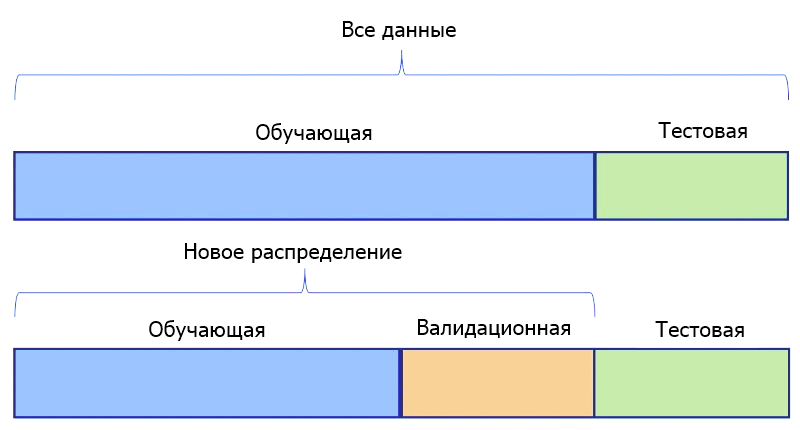

Делить выборки будем в соотношении 3:1:1 (train: valid:test).

Для начала разделим датасет на обучающую и тестовую выборки в соотношении 3:2 

In [16]:
features = data.drop(['is_ultra'], axis=1)

target = data['is_ultra']

features_train, features_test, target_train, target_test = train_test_split(features, target, 
                                                    test_size=0.4, 
                                                    random_state=12345,
                                                    stratify=target)

print(f"Количество строк в target_train по классам: {np.bincount(target_train)}")
print(f"Количество строк в target_test по классам: {np.bincount(target_test)}")

Количество строк в target_train по классам: [1337  591]
Количество строк в target_test по классам: [892 394]


In [17]:
features_test, features_valid, target_test, target_valid = train_test_split(features_test, target_test, 
                                                    test_size=0.5, 
                                                    random_state=12345,
                                                    stratify= target_test)

print(f"Количество строк в target_test по классам: {np.bincount(target_test)}")
print(f"Количество строк в target_valid по классам: {np.bincount(target_valid)}")

Количество строк в target_test по классам: [446 197]
Количество строк в target_valid по классам: [446 197]


### 1. Решающее дерево

*Для решающего дерева важным гиперпараметром при обучении модели является max_depth - максимальная глубина. Нужно выбрать оптимальную глубину. Обычно, считается, что при глубине <4 модель недообучится. А при глубине >4 уже переобучится*

In [18]:
best_model_tree=None # принято указывать None
best_result_tree = 0 

accuracy_tree_valid = []
accuracy_tree_train =[]
depth_plot =[]

train_errors = []
valid_errors = []

for depth in range(1,30):
    # обучение модели с заданной глубиной дерева
    model_tree = DecisionTreeClassifier(random_state=12345, max_depth = depth)
    
    # обучение модели на обучающей выборке с помощью метода fit()
    model_tree.fit(features_train, target_train)

    accuracy_tree_valid.append(model_tree.score(features_valid, target_valid)) # собираем значения accuracy для модели на valid
    accuracy_tree_train.append(model_tree.score(features_train, target_train)) # собираем значения accuracy for model on train
    depth_plot.append(depth) # список со значением глубины

    train_errors.append(1 - model_tree.score(features_train, target_train))
    valid_errors.append(1 - model_tree.score(features_valid, target_valid))
    
    
    # получение предсказания на валидационной выборке
    predictions_valid_tree = model_tree.predict(features_valid)
    
    # измерение качества модели на валидационной выборке
    result_tree= accuracy_score(target_valid, predictions_valid_tree) 
 
    if result_tree> best_result_tree:
        best_model_tree = model_tree # сохраняем наилучшую модель
        best_result_tree = result_tree # сохраняем наилучшее значение метрики accuracy
        
print('Accuracy наилучшей модели на валидационной выборке:', best_result_tree)
print('Глубина наилучшей модели:', best_model_tree)

Accuracy наилучшей модели на валидационной выборке: 0.8118195956454122
Глубина наилучшей модели: DecisionTreeClassifier(max_depth=5, random_state=12345)


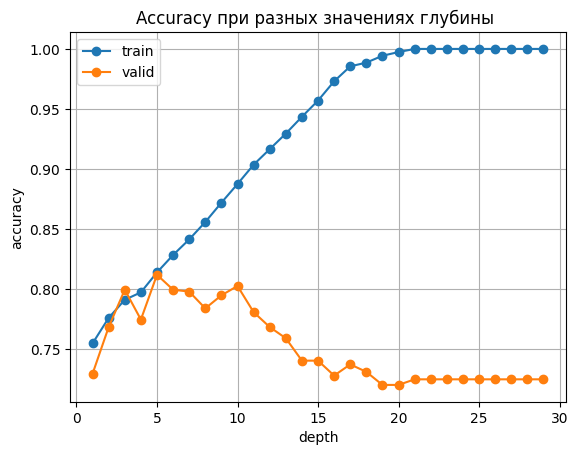

In [19]:
valid = pd.Series(accuracy_tree_valid)
train = pd.Series(accuracy_tree_train)
depth = pd.Series(depth_plot)

valid_df = valid.to_frame (name='valid')
train_df = train.to_frame (name='train')
depth_df = depth.to_frame (name='depth')

#concatenate three Series into one DataFrame
df_plot = pd.concat([valid_df, train_df, depth_df], axis= 1 )


df_plot.pivot_table(index= 'depth', values =['valid', 'train']).plot(marker ='o')
plt.title('Accuracy при разных значениях глубины ')
plt.ylabel('accuracy')
plt.xlabel('depth')
plt.grid(True)
plt.show()

> на графике видно следующее:
>* accuracy for valid сначала возрастает, затем увеличивается при увеличении глубины дерева
>* accuracy for train возрастает, а потом вовсе становится const

> Вывод: 
>1. accuracy for valid наилучшая до max_depth=11
>2. accuracy на трейне бессмысленно проверять, модель эти значения запомнила
>3. Видно, что произошло переобучение: модель хорошо объясняет примеры из обучающей выборке, но относительно плохо работает на валидации

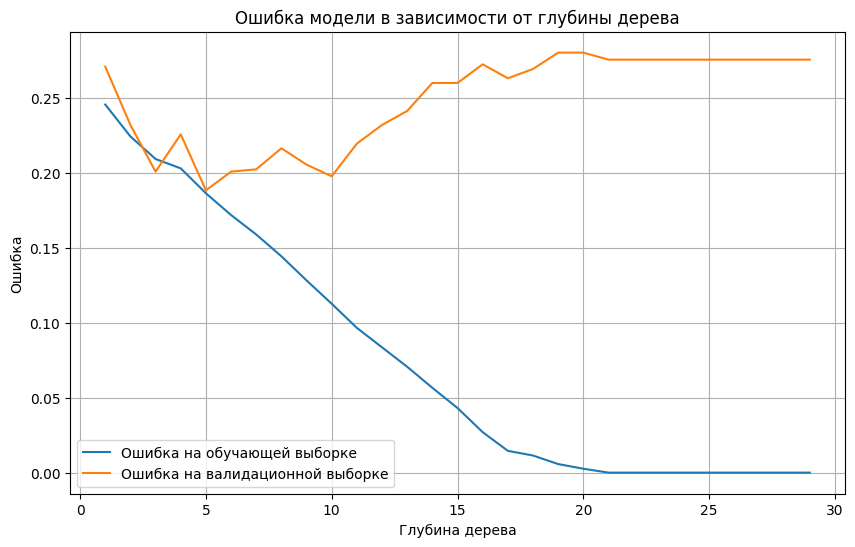

In [20]:
plt.figure(figsize=(10, 6))
plt.plot(range(1, 30), train_errors, label="Ошибка на обучающей выборке")
plt.plot(range(1, 30), valid_errors, label="Ошибка на валидационной выборке")
plt.xlabel("Глубина дерева")
plt.ylabel("Ошибка")
plt.legend()
plt.grid(True)
plt.title("Ошибка модели в зависимости от глубины дерева")
plt.show()

Наблюдается переобучение. То есть модель хорошо объяснила примера из train данных, но не смогла ответить правильно в valid (запуталась). Метрика на трейне в конце становится константой, а метрика на valid  уменьшается

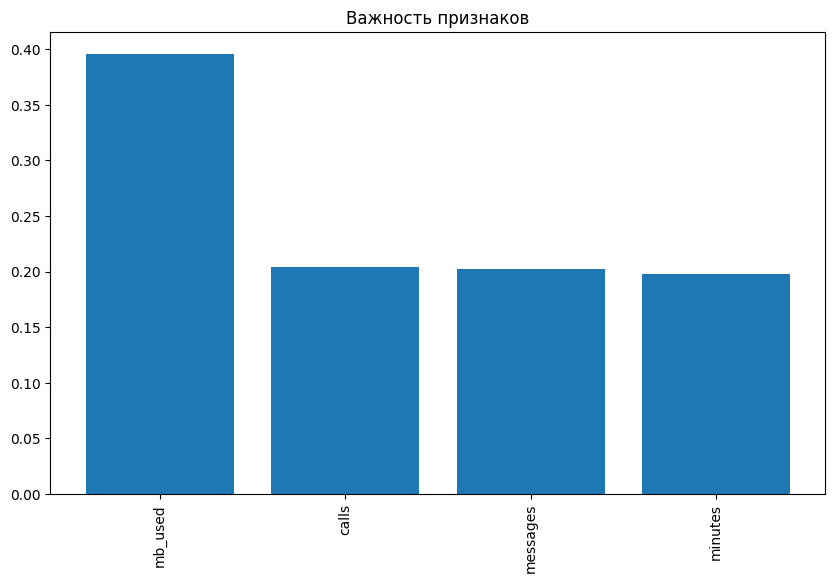

In [21]:
# Получение важности признаков
importances_tree = model_tree.feature_importances_
indices_tree = np.argsort(importances_tree)[::-1]

# Визуализация важности признаков
plt.figure(figsize=(10, 6))
plt.title("Важность признаков")
plt.bar(range(features_train.shape[1]), importances_tree[indices_tree], align="center")
plt.xticks(range(features_train.shape[1]), features_train.columns[indices_tree], rotation=90)
plt.show()

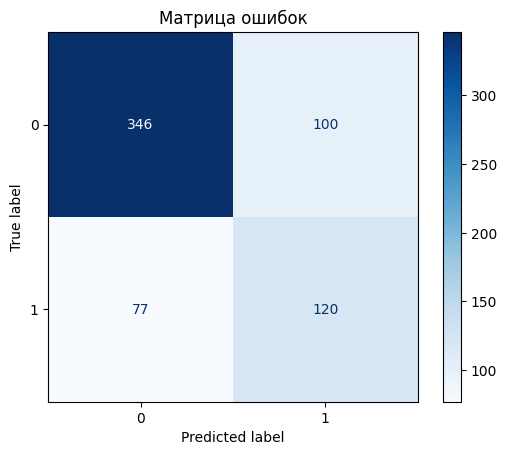

In [22]:
cm = confusion_matrix(target_valid, model_tree.predict(features_valid))
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Blues)
plt.title("Матрица ошибок")
plt.show()

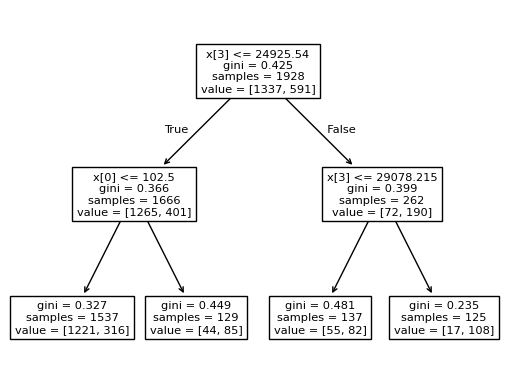

In [23]:
# Визуализация дерева
model_tree_visualization = DecisionTreeClassifier(random_state=12345, max_depth = 2)
model_tree_visualization.fit(features_train, target_train)
tree.plot_tree(model_tree_visualization);

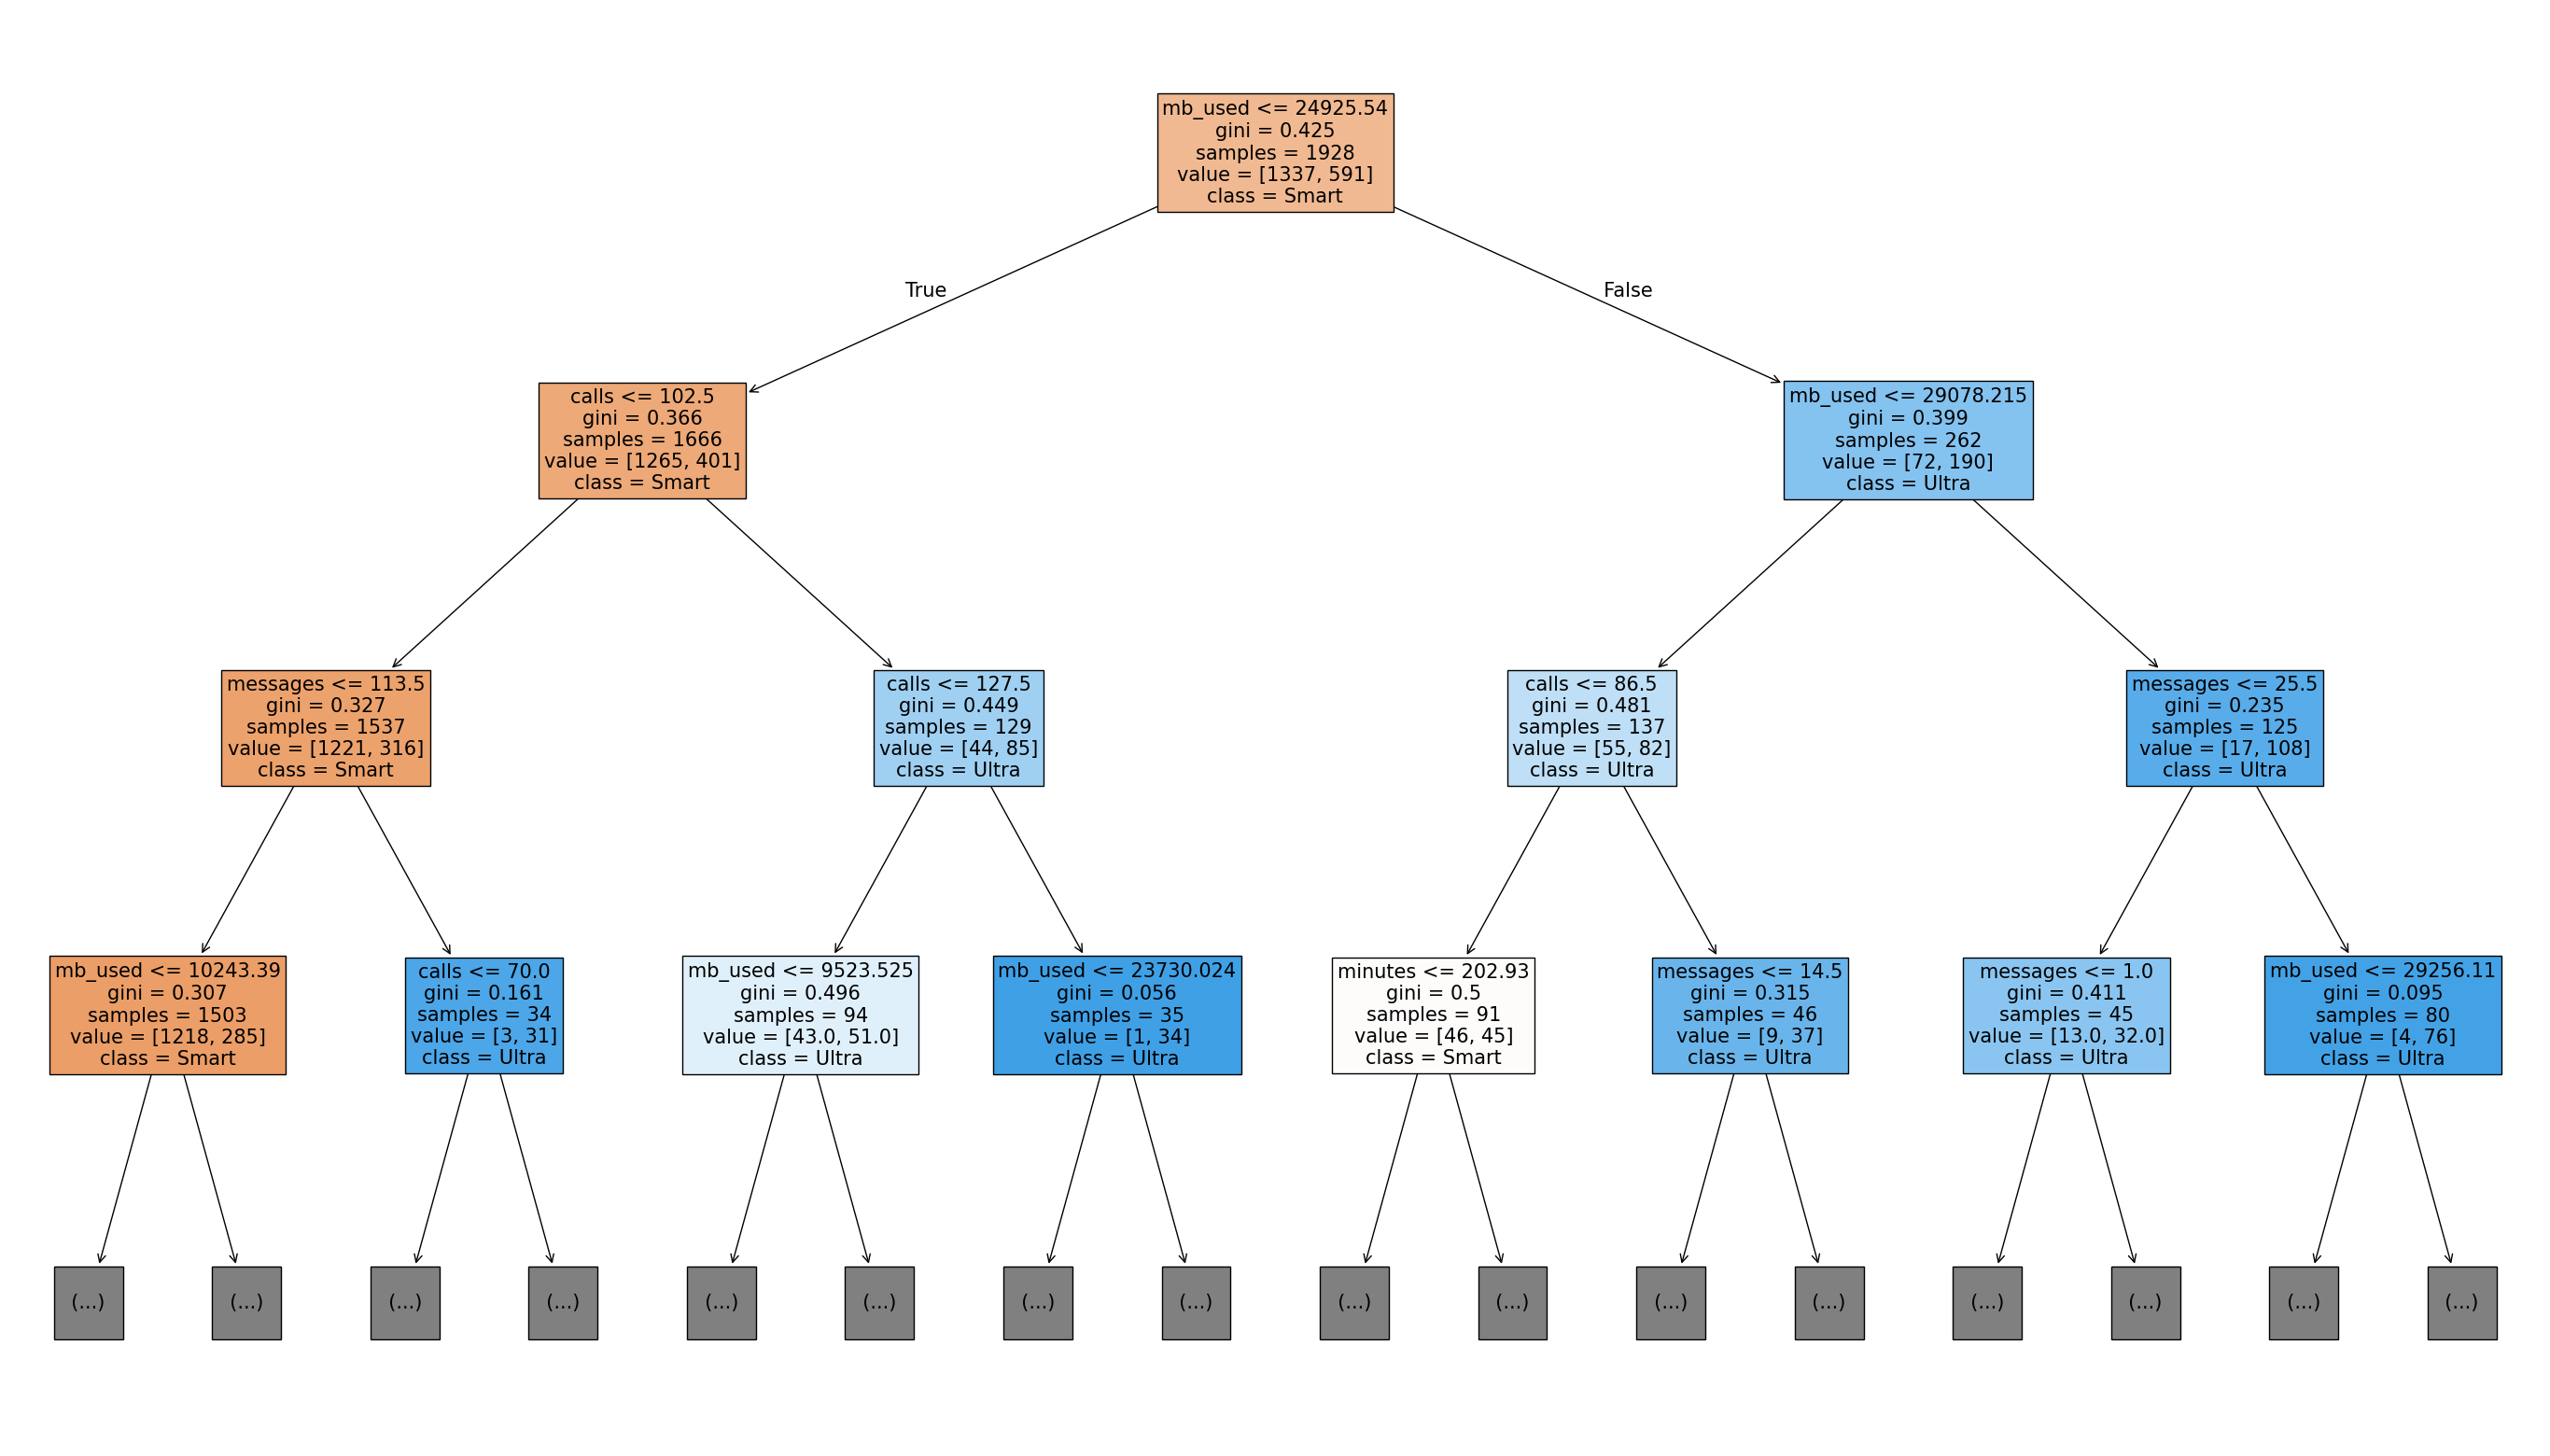

In [24]:
fig = plt.figure(figsize=(35,20))
good_tree= tree.plot_tree(best_model_tree, 
                   feature_names=features.columns.values, 
                   class_names=['Smart','Ultra'],
                   filled=True,
                   fontsize = 15,
                   max_depth = 3   
                      )
good_tree;

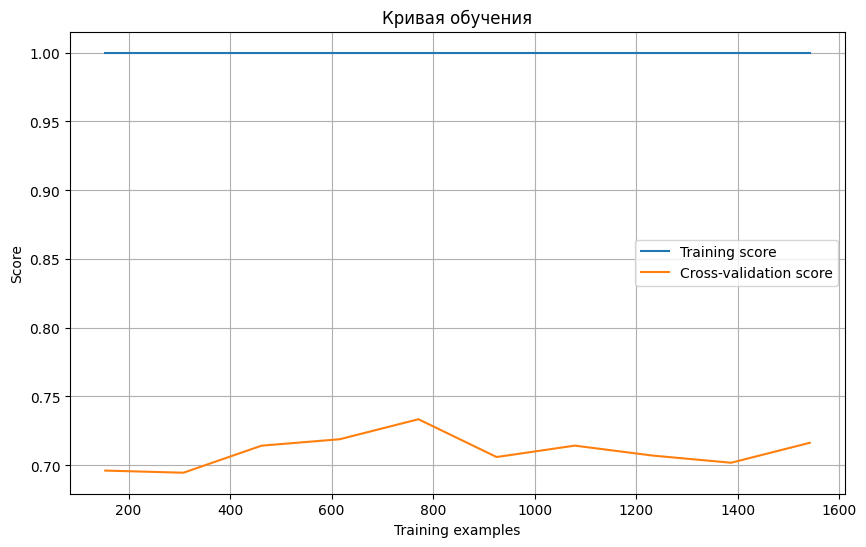

In [25]:
# Кривая обучения: показывает, как производительность модели зависит от размера обучающей выборки.
train_sizes, train_scores, valid_scores = learning_curve(
    model_tree, features_train, target_train, cv=5, scoring='accuracy', n_jobs=-1,
    train_sizes=np.linspace(0.1, 1.0, 10)
)

plt.figure(figsize=(10, 6))
plt.plot(train_sizes, np.mean(train_scores, axis=1), label="Training score")
plt.plot(train_sizes, np.mean(valid_scores, axis=1), label="Cross-validation score")
plt.xlabel("Training examples")
plt.ylabel("Score")
plt.title("Кривая обучения")
plt.legend()
plt.grid(True)
plt.show()


### 2. Случайный лес

*Для случайного леса важным гиперпараметром является количество деревьев: n_estimators*

In [26]:
best_model_forest=None # принято указывать None
best_result_forest = 0


oob_error = []

for est in tqdm(range(1, 32), desc='💤 '):
    for depth in range(1, 15):
            
        # обучение модели с заданным количеством деревьев
        model_forest = RandomForestClassifier(random_state=12345, n_estimators = est, max_depth = depth, oob_score=True)
    
        # обучение модели на обучающей выборке с помощью метода fit()
        model_forest.fit(features_train, target_train)

        # измерение качества модели на валидационной выборке
        result_forest= model_forest.score(features_valid, target_valid)

        oob_error.append(1 - model_forest.oob_score_)
    
        if result_forest> best_result_forest:
            best_model_forest = model_forest # сохраняем наилучшую модель
            best_result_forest = result_forest # сохраняем наилучшее значение метрики
        
print('Accuracy наилучшей модели на валидационной выборке:', best_result_forest)
print('Количество деревьев и глубина наилучшей модели:', best_model_forest)

💤 : 100%|██████████| 31/31 [00:54<00:00,  1.76s/it]

Accuracy наилучшей модели на валидационной выборке: 0.8242612752721618
Количество деревьев и глубина наилучшей модели: RandomForestClassifier(max_depth=12, n_estimators=31, oob_score=True,
                       random_state=12345)


In [27]:
# plt.figure(figsize=(10, 6))
# plt.plot(range(1, 435), oob_error, label="OOB Error")
# plt.xlabel("Количество деревьев")
# plt.ylabel("Ошибка OOB")
# plt.title("OOB Error в зависимости от количества деревьев")
# plt.grid(True)
# plt.show()

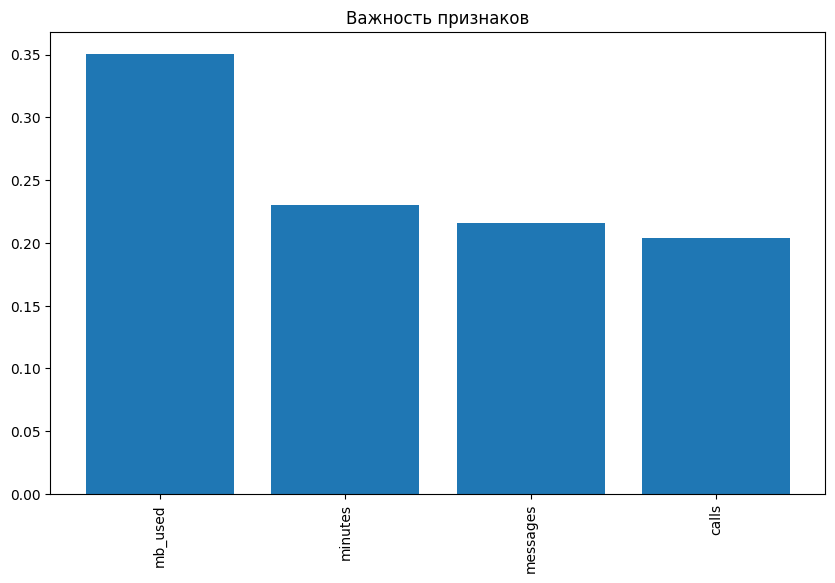

In [28]:
# Получение важности признаков
importances_forest = model_forest.feature_importances_
indices_forest = np.argsort(importances_forest)[::-1]

# Визуализация важности признаков
plt.figure(figsize=(10, 6))
plt.title("Важность признаков")
plt.bar(range(features_train.shape[1]), importances_forest[indices_forest], align="center")
plt.xticks(range(features_train.shape[1]), features_train.columns[indices_forest], rotation=90)
plt.show()

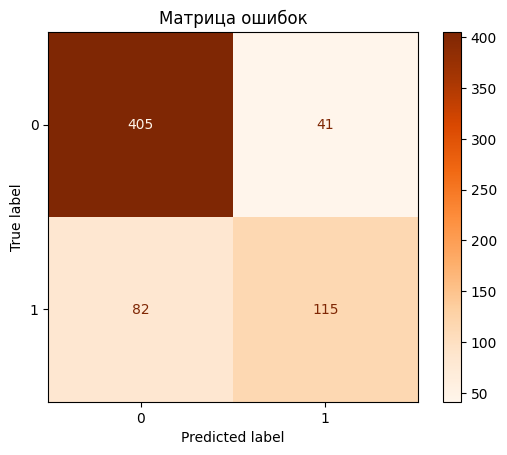

In [29]:
cm = confusion_matrix(target_valid, model_forest.predict(features_valid))
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Oranges)
plt.title("Матрица ошибок")
plt.show()

>наилучшая модель *случайного леса* оказалась  с количеством деревьев 31, максимальной глубиной 12 и значением правильности ~0,8243. по матрице ошибок видно, что модель неплохо предсказывает 

In [30]:
# конкатенация features_train c features_valid
# и target_train c target_valid
df_features_for_gridcv = pd.concat([features_train, features_valid])
df_target_for_gridcv = pd.concat([target_train,target_valid])

In [31]:
# %%time
# # ~10m
# # объявляем классификатор RandomForest, не внося в него никаких параметров:
# clf = RandomForestClassifier()

# # Отдельно создаем словарик, в который вписываем параметры, которые будем прогонять GridSearch’ем. 
# parametrs = {'n_estimators':range(1, 50),
#              'max_depth': range (1, 20)}

# # Запускаем обучение
# grid = GridSearchCV(clf, parametrs, cv=5)
# grid.fit(df_features_for_gridcv, df_target_for_gridcv)


# grid.best_params_
# grid.best_estimator_
# grid.best_score_
# grid.cv_results_

In [32]:
model_forest_cv = RandomForestClassifier(random_state=12345, n_estimators=32, max_depth=15, oob_score=True)
best_result_forest_cv = cross_val_score(model_forest_cv, df_features_for_gridcv, df_target_for_gridcv, cv=5, scoring='accuracy').mean()
print('Средняя точность на кросс-валидации:', best_result_forest_cv)

Средняя точность на кросс-валидации: 0.7934607683880472


### 3. Логистическая регрессия

*Для логистической регрессии гиперпараметром является max_iter: количество итераций*

In [33]:
model_logistic = LogisticRegression(random_state=12345, solver = 'lbfgs', max_iter = 10000)

# обучение модели на обучающей выборке с помощью метода fit()
model_logistic.fit(features_train, target_train)

best_result_logistic =  model_logistic.score(features_valid, target_valid)

print('Accuracy модели логистической регрессии:', best_result_logistic)

Accuracy модели логистической регрессии: 0.7465007776049767


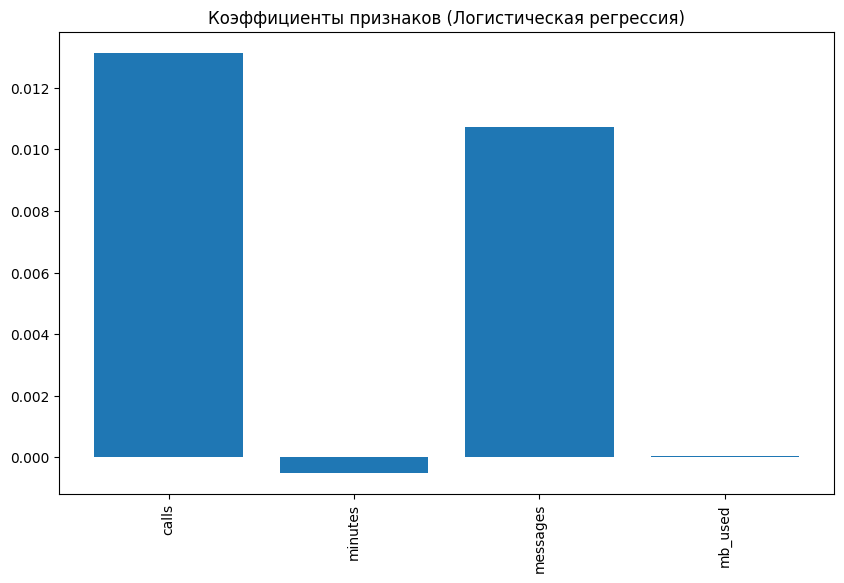

In [34]:
# Логистическая регрессия позволяет интерпретировать влияние каждого признака на вероятность 
# отнесения объекта к тому или иному классу через коэффициенты.
coef = model_logistic.coef_[0]
plt.figure(figsize=(10, 6))
plt.bar(range(len(coef)), coef)
plt.xticks(range(len(coef)), features_train.columns, rotation=90)
plt.title("Коэффициенты признаков (Логистическая регрессия)")
plt.show()


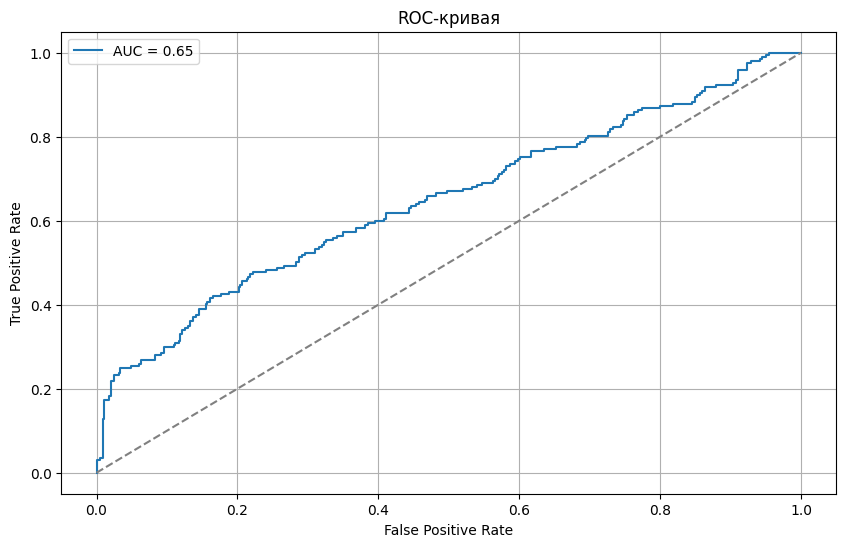

In [35]:
# График ROC показывает соотношение между истинно положительными и ложноположительными 
# срабатываниями для модели, что помогает оценить её производительность.

probabilities = model_logistic.predict_proba(features_test)[:, 1]
fpr, tpr, thresholds = roc_curve(target_test, probabilities)
roc_auc = roc_auc_score(target_test, probabilities)

plt.figure(figsize=(10, 6))
plt.plot(fpr, tpr, label=f'AUC = {roc_auc:.2f}')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC-кривая")
plt.legend()
plt.grid(True)
plt.show()


модель плохо предсказывает таргеты, вероятнее, из-за того, что у фичей и таргетов нелинейная зависимость

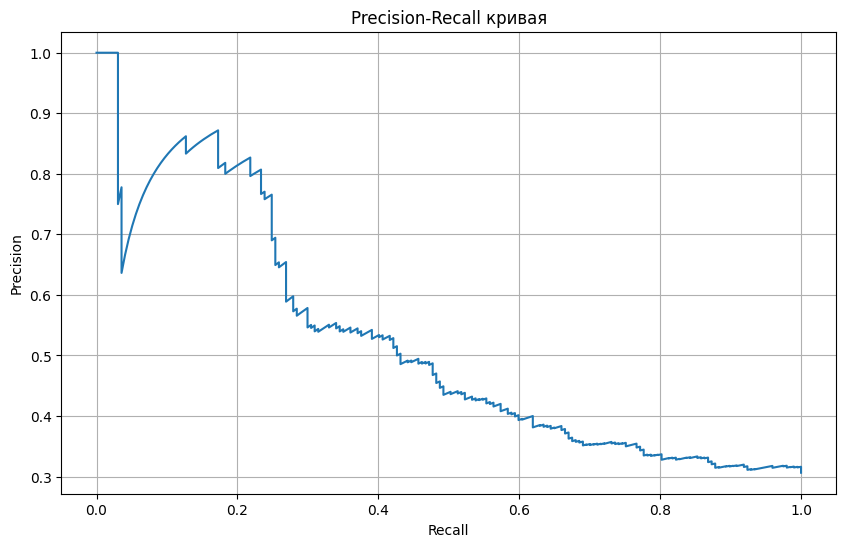

In [36]:
#  Precision-Recall кривая
# Показывает зависимость между точностью (precision) и полнотой (recall) при различных порогах вероятности для принятия решения
precision, recall, thresholds = precision_recall_curve(target_test, probabilities)

plt.figure(figsize=(10, 6))
plt.plot(recall, precision)
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall кривая")
plt.grid(True)
plt.show()

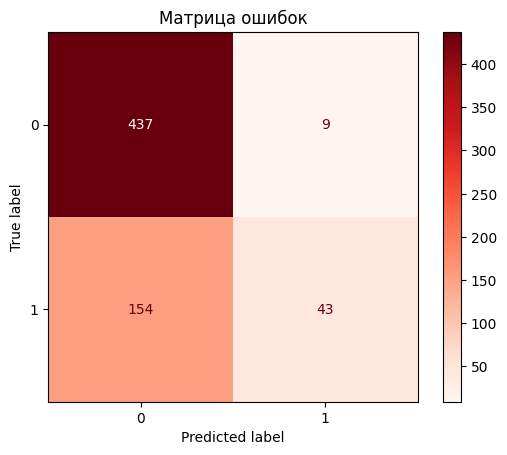

In [37]:
cm = confusion_matrix(target_valid, model_logistic.predict(features_valid))
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Reds)
plt.title("Матрица ошибок")
plt.show()

>наилучшая модель логистической регрессии оказалась с accuracy ~0,7465. по матрице ошибок видно, что модель ошибается

-----

# Анализ моделей

---

In [38]:
# ниже есть пример с масштабированием данных и использованием метрики f1
table = {
    'Model': ['DecisionTreeClassifier',
              'RandomForestClassifier',
              'RandomForestClassifier_CV',
              'LogisticRegression'],
    
    'Accuracy': [best_result_tree,
                 best_result_forest,
                 best_result_forest_cv,
                 best_result_logistic],

    # 'Наилучшие параметры': [best_model_tree,
    #                         best_model_forest,
    #                         "",
    #                         ""],
}
table_scan = pd.DataFrame(data = table)
table_scan

,Model,Accuracy
0,DecisionTreeClassifier,0.811820
1,RandomForestClassifier,0.824261
2,RandomForestClassifier_CV,0.793461
3,LogisticRegression,0.746501


# Проверка качества модели на тестовой выборке.

In [39]:
#Проверка наилучшей модели случайного леса на test
model_forest = RandomForestClassifier(max_depth=12, n_estimators=31, random_state=12345)
    
#обучение на обучащей выборке
model_forest.fit(features_train, target_train)

print("Наилучшая модель: случайный лес")
print("Accuracy случайного леса на тестовой выборке: ", model_forest.score(features_test, target_test)) 

Наилучшая модель: случайный лес
Accuracy случайного леса на тестовой выборке:  0.7978227060653188


> Проверка удалась. Аccuracy  на valid была 0,8243. На тесте чуть подвела: 0,7978

## Проверка модели на вменяемость

Тестовая выборка- имитация реальных данных

In [40]:
model_dummy = DummyClassifier(strategy='prior')
model_dummy.fit(features_train, target_train)
predict = model_dummy.predict(features_test)
print('Accuracy при проверке на дамми-ловушку', model_dummy.score(predict, target_test))
print('Accuracy лучшей модели RF:', model_forest.score(features_valid, target_valid))

Accuracy при проверке на дамми-ловушку 0.6936236391912908
Accuracy лучшей модели RF: 0.8242612752721618


is_ultra
Cмарт     0.693528
Ультра    0.306472
Name: proportion, dtype: float64


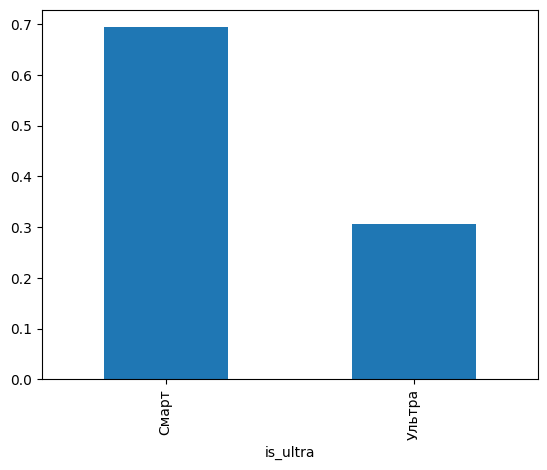

In [41]:
# Вспомним как распределены тарифы в исходном датасете
class_data = data_visualization['is_ultra'].value_counts(normalize = 2/len(data['is_ultra']))
print(class_data)
class_data.plot(kind='bar');

0    0.757387
1    0.242613
Name: proportion, dtype: float64


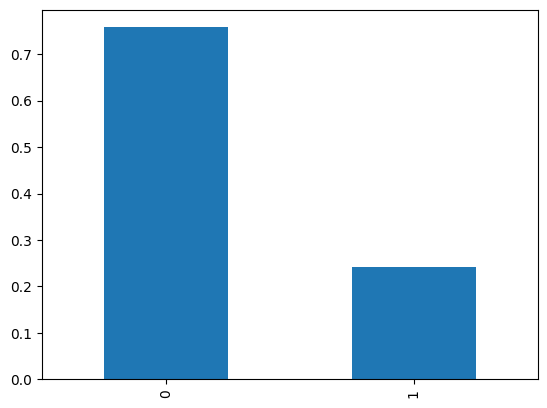

In [42]:
# Теперь посмотрим какие тарифы предсказывает модель случайного леса
# чтобы функция value_counts() работала,надо преобразовать результат к pd.Series 
predicted_valid_forest = pd.Series(model_forest.predict(features_valid))

class_model_forest = predicted_valid_forest.value_counts(2/len(features_valid))
print(class_model_forest)
class_model_forest.plot(kind='bar');

**Значит:**
1. Модель случайного леса попала в дамми-ловушку 
DummyClassifier (strategy='prior') предсказывает только один из классов (prior - выбирает больший класс: Смарт). Accuracy достаточно большая для того, что модель предсказывает только отрицательный класс.
**Вывод из этого:** нужно экспериментировать с другими метриками

2. Сама модель хорошо предсказывает отрицательный и положительный классы

---

<h1>Вывод:<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"></ul></div>

Модель решающего дерева сильно конкурирует с моделью случайного леса. 

Результаты решающего дерева:
* accuracy valid 0,81182
* accuracy test 0,7854


Результаты случайного леса:
* accuracy valid 0,8243
* accuracy test 0,7947

*При проверке на вменямость модель попала в дамми-ловушку, но accuracy показала неплохой результат. Чтобы этого избежать лучше использовать другие метрики(F1, например)*

*Сравнивая эти две модели, были также построены гистограммы предсказаний классов. Модель RF чаще предсказывает тариф Cмарт, чем модель DT*

**Для решения поставленной задачи предпочтительнее использовать модель случайного леса, так как у нее метрива accuracy была ваше даже при проверке на тестовой выборке. Зависимость в данных у нас сложнее, чем просто линейная, поэтому логистическая регрессия не справилась**

In [43]:
# Промасштабируем данные
scaler = StandardScaler()
scaler.fit(features_train)

features_train_scaled = scaler.transform(features_train)
features_test_scaled = scaler.transform(features_test)
features_valid_scaled = scaler.transform(features_valid)

In [44]:
best_model_scaled=None # принято указывать None
best_result_scaled = 0


for est in tqdm(range(1, 32), desc='💤 '):
    for depth in range(1, 15):
            
        # обучение модели с заданным количеством деревьев
        model_scaled = RandomForestClassifier(random_state=12345, n_estimators = est, max_depth = depth)
    
        # обучение модели на обучающей выборке с помощью метода fit()
        model_scaled.fit(features_train_scaled, target_train)

        predicted_scaled = model_scaled.predict(features_valid_scaled)
        
        # измерение качества модели на валидационной выборке
        result_scaled= f1_score(target_valid, predicted_scaled)
    
        if result_scaled> best_result_scaled:
            best_model_scaled = model_scaled # сохраняем наилучшую модель
            best_result_scaled = result_scaled # сохраняем наилучшее значение метрики
        
print('f1 наилучшей модели на валидационной выборке:', best_result_scaled)
print('Количество деревьев и глубина наилучшей модели:', best_model_scaled)

💤 : 100%|██████████| 31/31 [00:49<00:00,  1.59s/it]

f1 наилучшей модели на валидационной выборке: 0.6816901408450704
Количество деревьев и глубина наилучшей модели: RandomForestClassifier(max_depth=12, n_estimators=31, random_state=12345)


In [45]:
#Проверка наилучшей модели  случайного леса на test
model_scaled = RandomForestClassifier(max_depth=12, n_estimators=31, random_state=12345)
    

model_scaled.fit(features_train_scaled, target_train) 

predicted_good_scaled = model_scaled.predict(features_test_scaled)

print("f1 случайного леса на тестовой выборке: ", f1_score(target_test,predicted_good_scaled )) 

f1 случайного леса на тестовой выборке:  0.6217008797653959


0    0.77605
1    0.22395
Name: proportion, dtype: float64


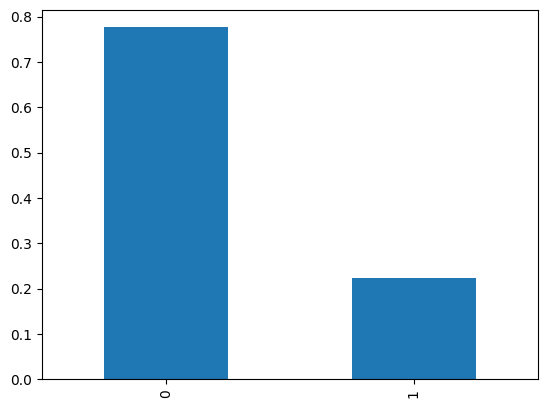

In [46]:
predicted_test_scaled = pd.Series(model_scaled.predict(features_test_scaled))

class_scaled = predicted_test_scaled.value_counts(2/len(features_test_scaled))
print(class_scaled)
class_scaled.plot(kind='bar');

> Результаты до масштабирования:
>* 0 - 0.757387
>* 1 - 0.242613

> То есть после масштабирования модель начала еще больше предсказывать тариф Смарт. Какая модель лучше: до масштабирования или после? Это уже зависит от бизнес-задачи: какой тариф они больше хотят предлагать клиентам(что больше прибыли приносит). 

In [47]:
#Проверка модели на вменяемость по масштабированным данным
model_scaled_dummy = DummyClassifier (strategy='prior')

model_scaled_dummy.fit(features_train_scaled, target_train)

predict_test_dummy = model_scaled_dummy.predict(features_test_scaled)

print('f1:', f1_score( predict_test_dummy, target_test ))
print('accuracy:', accuracy_score(predict_test_dummy, target_test))

f1: 0.0
accuracy: 0.6936236391912908


> Видно, как f1-мера упала при проверке на дамми ловушку. А accuracy продолжает держаться на высоте. По f1 сразу понятно, что модель попала в дамми-ловушку